# SETUP

In [71]:
import os
import json
from matplotlib import pyplot as plt
import math
import numpy as np
import pandas as pd
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
import pickle
plt.rcParams.update({'font.size': 22})
plt.show() # need to call show so will update default params above
# color blind friendly colors
# https://gist.github.com/thriveth/8560036
color_blinds = {
    'blue':   [55/255,  126/255, 184/255],  #377eb8 
    'orange': [255/255, 127/255, 0/255],    #ff7f00
    'green':  [77/255,  175/255, 74/255],   #4daf4a
    'pink':   [247/255, 129/255, 191/255],  #f781bf
    'brown':  [166/255, 86/255,  40/255],   #a65628
    'purple': [152/255, 78/255,  163/255],  #984ea3
    'gray':   [153/255, 153/255, 153/255],  #999999
    'red':    [228/255, 26/255,  28/255],   #e41a1c
    'yellow': [222/255, 222/255, 0/255]     #dede00
} 
color_blinds_list = [color_blinds[color] for color in color_blinds]

In [2]:
train_path = 'local/runs/example_dqn/'
binvox_path = train_path + 'map_voxels.binvox'
model_path = train_path + 'model.zip'

train_log_path = train_path + 'log.txt'
train_configuration_path = train_path + 'configuration.json'
train_states_path = train_path + 'states/'

test_path = train_path + 'test/'
test_log_path = test_path + 'log.txt'
test_configuration_path = test_path + 'configuration.json'
test_states_path = test_path + 'states/'

# Configuration

In [3]:
train_configuration = json.load(open(train_configuration_path, 'r'))
test_configuration = json.load(open(test_configuration_path, 'r'))

# access neural networks

In [4]:
from stable_baselines3 import DQN as sb3DQN
mdl = sb3DQN.load(model_path)
mdl.policy

# from stable_baselines3 import TD3 as sb3TD3
# mdl = sb3TD3.load(model_path)
# mdl.actor

DQNPolicy(
  (q_net): QNetwork(
    (features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (q_net): Sequential(
      (0): Linear(in_features=200, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=6, bias=True)
    )
  )
  (q_net_target): QNetwork(
    (features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (q_net): Sequential(
      (0): Linear(in_features=200, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=6, bias=True)
    )
  )
)

# read states

In [5]:
# json files output with all string key names
# process so that the evaluation dictionary structure is such:
    # episode # - int
        # step # - int
            # state - dictionary of misc key, value pairs for that state
def process_episodes(json_evaluation):
    nEpisodes = len(json_evaluation)
    episodes = [None] * nEpisodes
    episode_idx = 0
    for episode_str in json_evaluation:
        if 'episode_' not in episode_str:
            continue
        json_episode = json_evaluation[episode_str]
        nSteps = len(json_episode)
        states = [None] * nSteps
        for step_str in json_episode:
            step_num = int(step_str.split('_')[1])
            state = json_episode[step_str]
            states[step_num] = state
        episodes[episode_idx] = states
        episode_idx += 1
    return episodes
def read_evaluations(evaluation_folder):
    evaluation_files = [file for file in os.listdir(evaluation_folder) if 'states' in file]
    nEvaluations = len(evaluation_files)
    evaluations = [None] * nEvaluations
    for evaluation_file in evaluation_files:
        if '.json' not in evaluation_file:
            continue
        epoch = int(evaluation_file.split('.')[0].split('_')[-1])
        #print(evaluation_file, epoch)
        json_evaluation = json.load(open(evaluation_folder + evaluation_file, 'r'))
        episodes = process_episodes(json_evaluation)
        evaluations[epoch] = episodes
    return evaluations
# architecture for evaluations:
# evaluations - list of episodes (indexed of evaluation number) - 0 idx is first evaluation
    # episodes - list of states (indexed by step number)
        # states - dict of (key, value) pairs for state at all_evaluations[instance][evaluation][episode][step]

In [6]:
# read evaluations from each instance
# each instance is a sub folder from parent with which this eval notebook is in
instances = [
    train_path + 'states',
    test_path + 'states',
    ]
all_evaluations = {}
for instance in instances:
    all_evaluations[instance] = read_evaluations(instance + '/')

# path accuracy

total accuracy = 75.0%


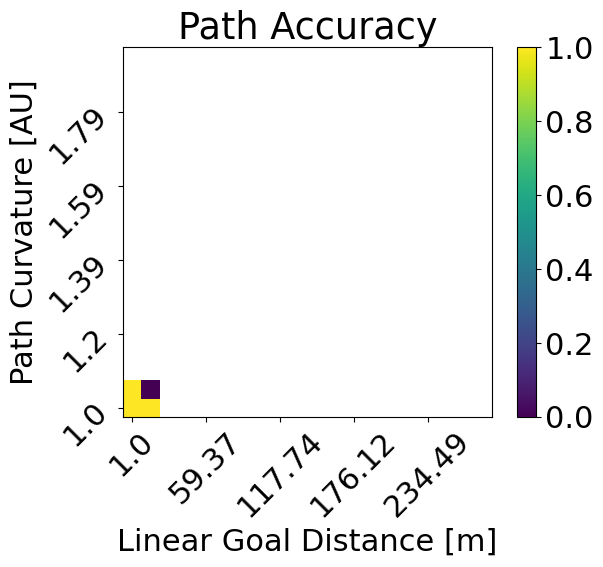

In [52]:
acc_instances = [
    #train_path + 'train_states',
    test_path + 'states',
]
goals = []
for instance in acc_instances:
    for set_num, episodes in enumerate(all_evaluations[instance]):
        for episode, states in enumerate(episodes):
            final_step = states[-1]
            goals.append(final_step['reached_goal'])
print(f'total accuracy = {np.round(100*np.mean(goals),2)}%')

# check against astar paths
path_idxs = pickle.load(open(test_path+'_static_path_idxs.p', 'rb'))
astar_paths = pickle.load(open('astar_paths/Blocks_2d_test.p', 'rb'))
linearity_bounds = astar_paths['linearity_bounds']
nonlinearity_bounds = astar_paths['nonlinearity_bounds']
goal_map = np.zeros([len(linearity_bounds), len(nonlinearity_bounds)]).astype(float)
total_map = np.zeros([len(linearity_bounds), len(nonlinearity_bounds)]).astype(float)
def get_bin(linearity, nonlinearity):
    for i in range(len(linearity_bounds)-1):
        if linearity < linearity_bounds[i+1]:
            for j in range(len(nonlinearity_bounds)-1):
                if nonlinearity < nonlinearity_bounds[j+1]:
                    return i, j
for idx, path_idx in enumerate(path_idxs):
    path = astar_paths['paths'][path_idx]
    #linearity = astar_paths['linearitys'][path_idx]
    #nonlinearity = astar_paths['nonlinearitys'][path_idx]
    linearity = np.linalg.norm(path[-1]-path[0])
    travel_distance = np.sum([np.linalg.norm(path[i+1]-path[i]) for i in range(len(path)-1)])
    nonlinearity = travel_distance/linearity
    goal = goals[idx]
    i, j = get_bin(linearity, nonlinearity)
    goal_map[i, j] += goal
    total_map[i, j] += 1
goal_map[total_map <= 0] = np.nan
total_map[total_map <= 0] = np.nan
acc_map = goal_map / total_map
fig, ax = plt.subplots()
cbar = ax.imshow(acc_map.T, origin='lower')
fig.colorbar(cbar)
plt.title('Path Accuracy')
delta = 4
ax.set_xticks([i for i in range(0, len(linearity_bounds), delta)], [np.round(linearity_bounds[i],2) for i in range(0, len(linearity_bounds), delta)], rotation=45)
ax.set_yticks([i for i in range(0, len(nonlinearity_bounds), delta)], [np.round(nonlinearity_bounds[i],2) for i in range(0, len(nonlinearity_bounds), delta)], rotation=45)
plt.xlabel('Linear Goal Distance [m]')
plt.xlabel('Linear Goal Distance [m]')
plt.ylabel('Path Curvature [AU]')
plt.show()

# map visualization

In [65]:
rooftops_dict = pickle.load(open('rooftops/Blocks.p', 'rb'))
rooftops_arr = []
for key in rooftops_dict:
    row = []
    for key2 in rooftops_dict[key]:
        row.append(rooftops_dict[key][key2])
    rooftops_arr.append(row)
rooftops_arr = np.array(rooftops_arr)
x_min = list(rooftops_dict.keys())[0]
y_min = list(rooftops_dict[x_min].keys())[0]
def plot_map(fig, ax):
    interval = 40
    im = ax.imshow(rooftops_arr, cmap='hot', interpolation='nearest', origin='lower')
    cbar = fig.colorbar(im, shrink=0.8)
    cbar.ax.get_yaxis().labelpad = 25
    cbar.ax.set_ylabel('z [meters]', rotation=270)
    ax.set_xticks([i for i in range(0, len(rooftops_arr[0]), interval)], 
              [y_min + i for i in range(0, len(rooftops_arr[0]), interval)], rotation=90)
    ax.set_yticks([i for i in range(0, len(rooftops_arr), interval)], 
              [x_min + i for i in range(0, len(rooftops_arr), interval)])
    ax.set_ylabel('x [meters]')
    ax.set_xlabel('y [meters')
    ax.set_aspect('equal')

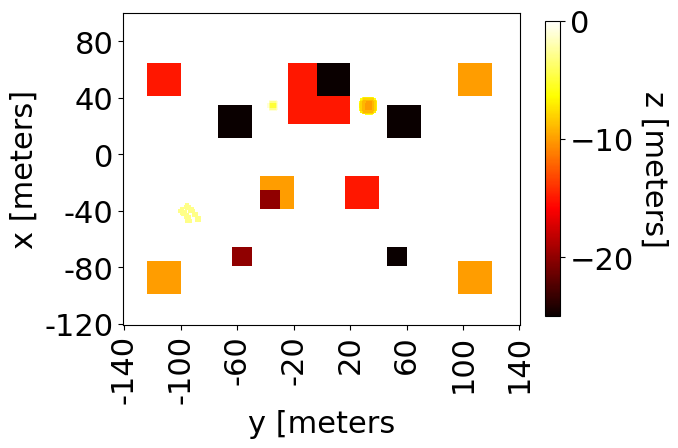

In [66]:
fig, ax = plt.subplots()
plot_map(fig, ax)

# analyze training metrics


In [68]:
# process final sate values
final_variables = {instance:{} for instance in instances}
for instance in instances:
    for set_num, episodes in enumerate(all_evaluations[instance]):
        for episode, states in enumerate(episodes):
            for step, state in enumerate(states):
                if step == 0:
                    if 'goal_distance' not in final_variables[instance]:
                        final_variables[instance]['goal_distance'] = {}
                    if episode not in final_variables[instance]['goal_distance']:
                        final_variables[instance]['goal_distance'][episode] = []
                    drone_position = np.array(state['drone_position'])
                    goal_position = np.array(state['goal_position'])
                    goal_distance = np.linalg.norm(goal_position - drone_position)
                    final_variables[instance]['goal_distance'][episode].append(goal_distance)
                    continue
            final_state = states[-1]
            for variable in final_state:
                if variable not in final_variables[instance]:
                    final_variables[instance][variable] = {}
                if episode not in final_variables[instance][variable]:
                    final_variables[instance][variable][episode] = []
                final_variables[instance][variable][episode].append(final_state[variable])

# architecture of final_variables:
# instance - str name
    # variable - str name
        # episode - int number
            # final values - list of final values with increased # of training evaluations 

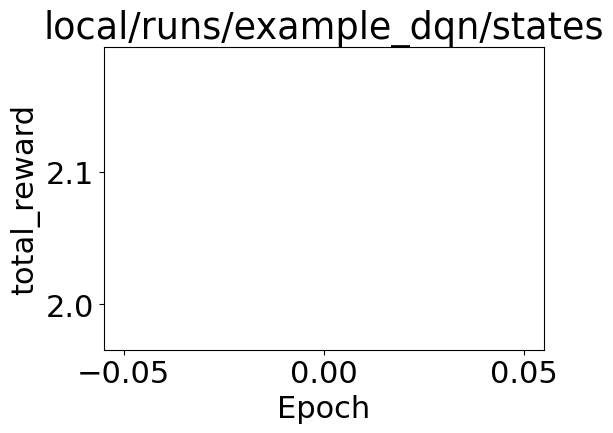

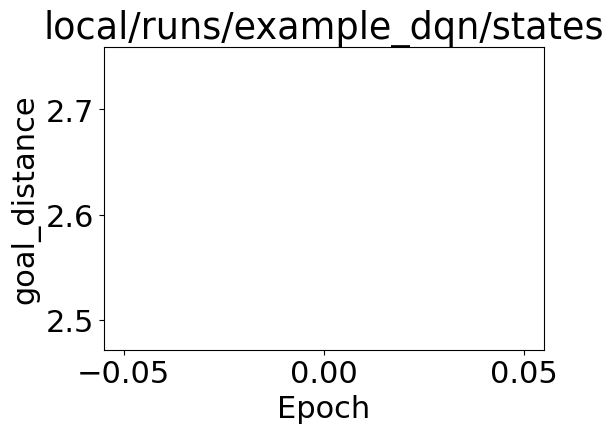

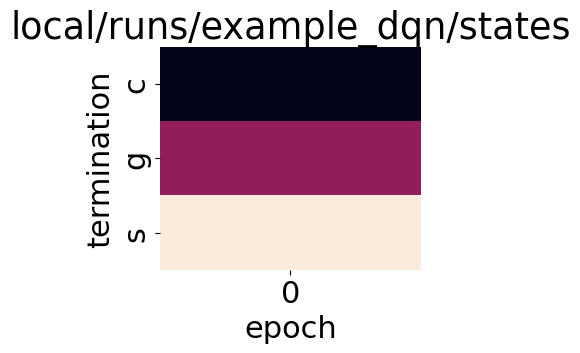

In [69]:
import seaborn as sns
# PLOT RESULTS VERSUS TRAINING TIME
results_instances = [
    train_path + 'states',
]
# select which state variables to fetch
numerical_variables = [
    #'nSteps', 
    'total_reward', 
    'goal_distance',
]
string_variables = [
    #'transcribed_action', 
    'termination_reason',
]
all_variables = numerical_variables + string_variables

shorten = {
    'termination_reason':'termination',
}

# take mean values
for variable in all_variables:
    for instance in results_instances:
        if variable not in shorten:
            shorten[variable] = variable
        plot_name = instance + '_' + variable
        
        values = {}
        for episode in final_variables[instance][variable]:
            for evaluation in range(len(final_variables[instance][variable][episode])):
                if evaluation not in values:
                    values[evaluation] = []
                values[evaluation].append(final_variables[instance][variable][episode][evaluation])

        if variable in numerical_variables:
            aggregates = []
            nEpisodes = len(final_variables[instance][variable])
            for evaluation in values:
                aggregates.append(sum(values[evaluation])/len(values[evaluation]))
            plt.title(instance)
            plt.xlabel('Epoch')
            plt.ylabel(variable)
            plt.plot(aggregates)
            plt.tight_layout()
            #fig = plt.gcf()
            #fig.set_size_inches(8, 4)
            #plt.savefig(plot_dir + plot_name + '.png')
            plt.show()

        if variable in string_variables:
            fig = plt.gcf()
            fig.set_size_inches(4, 4)
            aggregates = {}
            for evaluation in values:
                for name in values[evaluation]:
                    if name not in aggregates:
                        aggregates[name] = {}
                    if evaluation not in aggregates[name]:
                        aggregates[name][evaluation] = 0
                    aggregates[name][evaluation] += 1   
            df_data = {'count':[], shorten[variable]:[], 'epoch':[]}
            for name in aggregates:
                for evaluation in values:
                    if evaluation not in aggregates[name]:
                        aggregates[name][evaluation] = 0
                    count = aggregates[name][evaluation]
                    df_data['count'].append(count)
                    df_data[shorten[variable]].append(name[0])
                    df_data['epoch'].append(evaluation)
            df = pd.DataFrame(df_data)
            heatmap_data = pd.pivot_table(df, values='count', index=[shorten[variable]], columns='epoch')
            sns.heatmap(heatmap_data, cbar=False)
            #plt.imshow(heatmap_data.to_numpy())
            plt.title(instance)
            plt.tight_layout()
            #plt.savefig(plot_dir + plot_name + '.png')
            plt.show()

# view learned navigation paths

0


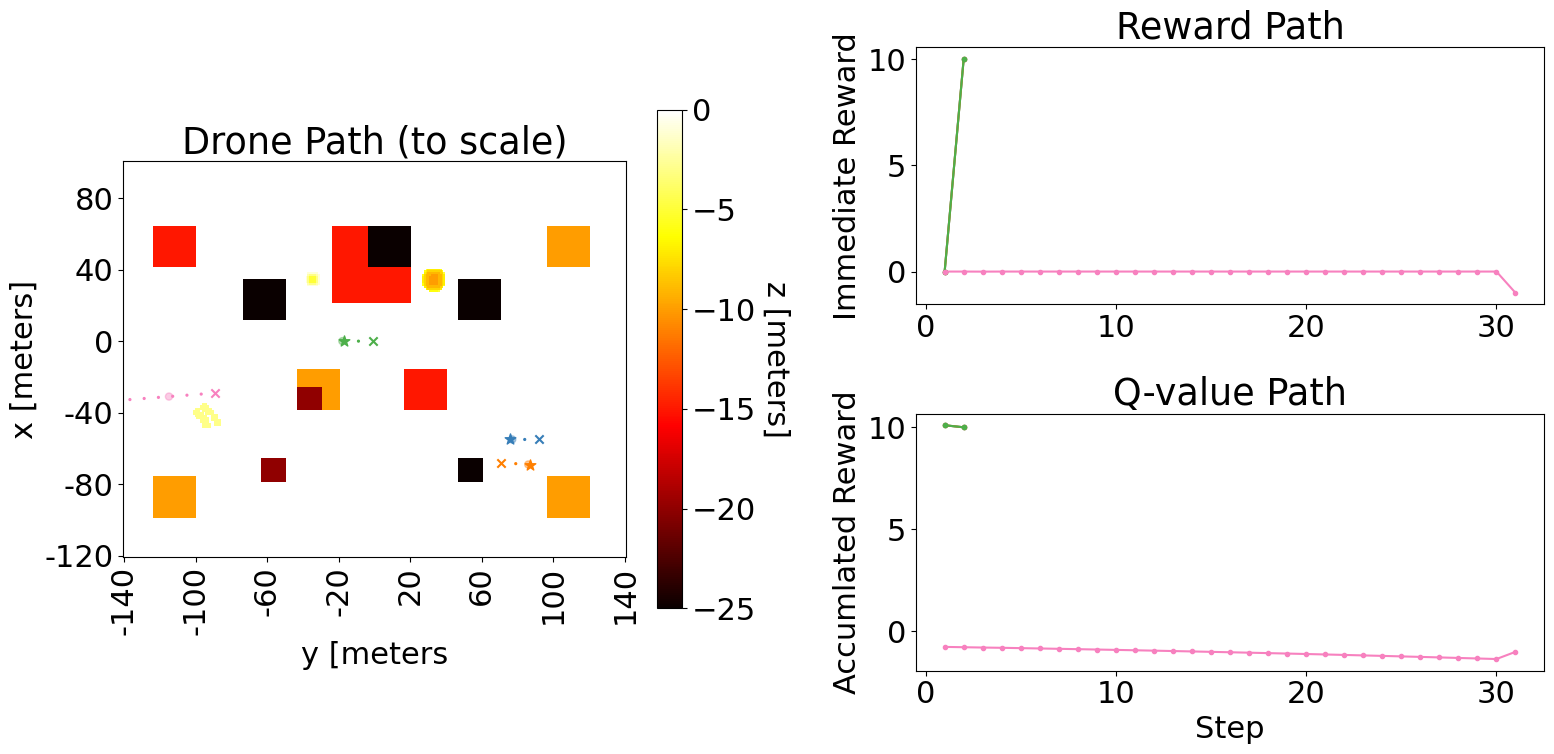

In [89]:
# PLOT PATHS (this is alot so you probably want to limit which ones to visualize
gamma = train_configuration['components']['Model']['gamma']
goal_tolerance = 2
path_instances = [
    #train_path + 'train_states',
    test_path + 'states',
]
for instance in path_instances:
    evaluations = all_evaluations[instance]
    for set_num, episodes in enumerate(evaluations):
        paths = []
        reward_paths = []
        Q_paths = []
        goals = []
        spawns = []
        termination_reasons = []
        episode_numbers = []
        # do we plot this set? (change as needed)
        view_set = True
        for episode, states in enumerate(episodes):
            # get final vaules
            final_state = episodes[episode][-1]
            reached_goal = final_state['reached_goal']
        if not view_set:
            continue
        for episode, states in enumerate(episodes):
            # get final vaules
            final_state = episodes[episode][-1]
            termination_reason = final_state['termination_reason']
            # build paths
            path = []
            reward_path = []
            Q_path = []
            episode_numbers.append(episode)
            # get initial value
            init_state = states[0]
            spawn = init_state['drone_position']
            goal = init_state['goal_position']
            # get intermediate values
            for step, state in enumerate(states):
                if step == 0: continue
                state = episodes[episode][step]
                drone_position = state['drone_position']
                path.append(drone_position)
                reward = state['total_reward']
                reward_path.append(reward)
                # get future values from this state
                for step2, state2 in enumerate(states[step+1:]):
                    if step == 0: continue
                    reward += (gamma**(step2-step)) * state2['total_reward']
                Q_path.append(reward)
            reward_paths.append(reward_path)
            termination_reasons.append(termination_reason)
            spawns.append(spawn)
            goals.append(goal)
            paths.append(path)
            Q_paths.append(Q_path)
            # plot every 8 episodes 
            if episode == len(episodes)-1 or (episode > 0 and episode%8 == 0):
                print(set_num)
                # subplots
                fig, axs = plt.subplots(nrows=2, ncols=2)
                fig.set_size_inches(16, 8)
                # remove the underlying Axes
                axs[0,0].remove()
                axs[0,1].remove()
                axs[1,0].remove()
                axs[1,1].remove()
                ax1 = plt.subplot2grid((2, 2), (0, 0), rowspan=2)
                ax2 = plt.subplot2grid((2, 2), (0, 1), colspan=1)
                ax3 = plt.subplot2grid((2, 2), (1, 1), colspan=1)
                # PLOT DRONE PATH
                ax1.set_title(f'Drone Path (to scale)')#' Epoch #{set_num}')
                # show objects on map from binvox
                plot_map(fig, ax1)
                # legend hack
                #ax1.scatter(-999, -999, marker='s', color=object_color) # off map just for legend
                legend = [
                #    'Objects'
                ]
                for idx in range(len(termination_reasons)):
                    color = color_blinds_list[idx]
                    ax1.scatter(spawns[idx][1] - y_min, spawns[idx][0] - x_min, marker='x', color=color) # spawn location
                    termination_reason = termination_reasons[idx]
                    legend.append('E' + str(episode_numbers[idx]) + ':' + termination_reason)
                plt_patches = []
                for idx in range(len(paths)):
                    color = color_blinds_list[idx]
                    # plot goal
                    obj = plt.Circle((goals[idx][1] - y_min, goals[idx][0] - x_min), goal_tolerance, color=color, alpha=0.4)
                    plt_patches.append(obj)
                    # plot points
                    for point in paths[idx]:
                        # using generic quad copter size for point sizes (set this to your drone value)
                        radius = 0.5 #* point[2]/-4
                        if point[1] < y_min or point[0] < x_min:
                            continue
                        point = plt.Circle((point[1] - y_min, point[0] - x_min), radius, color=color)
                        plt_patches.append(point)
                    # plot end point
                    if paths[idx][-1][1] >= y_min and paths[idx][-1][0] >= x_min:
                        ax1.scatter(paths[idx][-1][1] - y_min, paths[idx][-1][0] - x_min, marker='*', s=64, color=color) # end location
                map_stuff = PatchCollection(plt_patches, match_original=True)
                ax1.add_collection(map_stuff)
                # PLOT REWARDS
                ax2.set_title('Reward Path')
                #ax2.set_xlabel('Step')
                ax2.set_ylabel('Immediate Reward')
                for idx in range(len(reward_paths)):
                    color = color_blinds_list[idx]
                    ax2.plot([i+1 for i in range(len(reward_paths[idx]))], reward_paths[idx], color=color, marker='.')
                # PLOT Q-VALUES
                ax3.set_title('Q-value Path')
                ax3.set_xlabel('Step')
                ax3.set_ylabel('Accumlated Reward')
                for idx in range(len(Q_paths)):
                    color = color_blinds_list[idx]
                    ax3.plot([i+1 for i in range(len(Q_paths[idx]))], Q_paths[idx], color=color, marker='.')
                # plot legend
                #ax2.legend(legend)
                plt.tight_layout()
                # Show the graph
                #plot_name = instance + '_best_path'
                #plt.savefig(plot_dir + plot_name + '.png')
                plt.show()
                # reset path arrays
                paths = []
                reward_paths = []
                Q_paths = []
                goals = []
                spawns = []
                termination_reasons = []
                episode_numbers = []

# view observations

In [ ]:
# view specific observations
# this example visualizes just the last episode from testing
nTimesteps = 4 # how many steps is set to look in past from config file
flattened_depth_size = [6,8]
min_d = 1
max_d = 100
min_o = -1*math.pi
max_o = math.pi
min_output = 0.1
max_output = 1
obs_instances = [
    #train_path + 'train_states',
    test_path + 'states',
]
for instance in obs_instances:
    # read observations
    files = [file for file in os.listdir(instance) if 'observations' in file]
    observations = {}
    for file in files:
        observation_set = np.load(instance + '/' + file, allow_pickle=True)
        observations.update(observation_set)
    for set_num, episodes in enumerate(all_evaluations[instance][:1]):
        for episode, states in enumerate(episodes[:1]):
            for step, state in enumerate(states[1:]):
                observation_name = state['observation_name']
                observation = observations[observation_name]
                vLength = int(len(observation) / nTimesteps)
                for n in range(nTimesteps):
                    # if following the example py file on the github it has this strucutre 
                    # you may need to change how this is visualized if edited
                    time_observation = observation[vLength*n:vLength*n+vLength]
                    flattened_depth = np.interp(time_observation[:-2],
                                                (min_output, max_output),
                                                (min_d, max_d), )
                    goal_distance = np.interp(time_observation[-2],
                                                (min_output, max_output),
                                                (min_d, max_d), )
                    goal_orientation = np.interp(time_observation[-1],
                                                (min_output, max_output),
                                                (min_o, max_o), )
                    print(f'{observation_name} at step={step} t={step-n} d={goal_distance} o={goal_orientation}')
                    plt.imshow(flattened_depth.reshape(flattened_depth_size), cmap='gray')
                    plt.show()